# 測試與使用訓練好的Model

In [1]:
!pip install openmim what-a-dict
!mim install mmdet

     |████████████████████████████████| 82 kB 135 kB/s eta 0:00:01
  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=0baa01dc0f9f9238cc589df55c6a843aa9a3aaaf015b93955a256553480373e7
  Stored in directory: /home/jovyan/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
  Attempting uninstall: Click
    Found existing installation: click 8.0.1
    Uninstalling click-8.0.1:
      Successfully uninstalled click-8.0.1
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpjjcx7jzb/mmdetection'...
remote: Enumerating objects: 24787, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 24787 (delta 1), reused 5 (delta 0), pack-reused 24771
Receiving objects: 100% (24787/24787), 37.71 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (17364/17364), done.
Note: checking out '73b4e65a6a30435ef6a35f405e3474a4

## Testing PISA result

In [13]:
# 最簡單來個config檔就結束了
# python tools/test.py config檔.py weight檔.pth --eval {bbox或者proposal(一樣)}
!python tools/test.py pisa_chess.py work_dirs/pisa_chess/latest.pth --eval bbox

/opt/conda/lib/python3.7/site-packages/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/opt/conda/lib/python3.7/site-packages/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: work_dirs/pisa_chess/latest.pth
[                                                  ] 0/29, elapsed: 0s, ETA:/opt/conda/lib/python3.7/site-packages/torch/nn/functional.p

## Inference

In [1]:
from mmdet.apis import init_detector, inference_detector

config_file = 'train_config.py'
checkpoint_file ="work_dirs/train_config/latest.pth"
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)

load checkpoint from local path: work_dirs/train_config/latest.pth


In [2]:
from glob import glob
from numpy.random import choice
imgs=glob('data/coco/test/*.jpg')
def random_show_inference(model):
# inference the demo image
    
    img=choice(imgs)
    result = inference_detector(model, img)
    list_contents=lambda rs: (model.CLASSES[rs[0]],list(rs[1][:,-1])) if len(rs[1])!=0 else None
    content=[_ for _ in map(list_contents,enumerate(result)) if _!=None]

    print(*content,sep="\n")
    model.show_result(img, result,
                      score_thr=0.2,
                      show=True,
                      text_color=(200, 200, 200),
                      font_size=32)

以上建好可以看inference result的部分

先看一下model內容，主要是feature extractor-> RPN (rpn_head) -> roi pooling (roi_head)

In [30]:
model

FasterRCNN(
  (backbone): ResNeXt(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

**抽取中間層output來看**

In [3]:
import torch.nn as nn
from wad import Dict

class FeatureInspector:
    def __init__(self,net):
        self.submodules=Dict({k:v for k,v in 
                              net._named_members(lambda x:nn.Module.named_modules(x))})
        self.vis=Dict()
    def hook_fn(self,m, i, o):
        self.vis[m.name.replace(".","_")] = o 
    def add_inspection(self,*names):
        
        for n in names:
            for name,layer in self.submodules.items():
                if n == name:
                    print("get", n)
                    layer.name=name
                    layer.register_forward_hook(self.hook_fn)
                    break

In [23]:
fi=FeatureInspector(model)

In [24]:
fi.add_inspection("rpn_head")
fi.add_inspection("roi_head.bbox_roi_extractor")
fi.add_inspection("roi_head.bbox_head")

get rpn_head
get roi_head.bbox_roi_extractor
get roi_head.bbox_head


('black-bishop', [0.9953367, 0.9831993])
('black-king', [0.99809533])
('black-knight', [0.9688117, 0.9573711])
('black-pawn', [0.99904186, 0.99881494, 0.99823546, 0.99804074, 0.99797183, 0.9979159, 0.99733645, 0.99685353])
('black-queen', [0.99717796])
('black-rook', [0.98976934, 0.96694905])
('white-bishop', [0.99875927, 0.9972367])
('white-king', [0.9968952])
('white-knight', [0.997829, 0.993397])
('white-pawn', [0.99737906, 0.9973742, 0.99718, 0.9971685, 0.99702734, 0.9959935, 0.9940164, 0.99344134])
('white-queen', [0.99920136])
('white-rook', [0.99501795, 0.9881225])


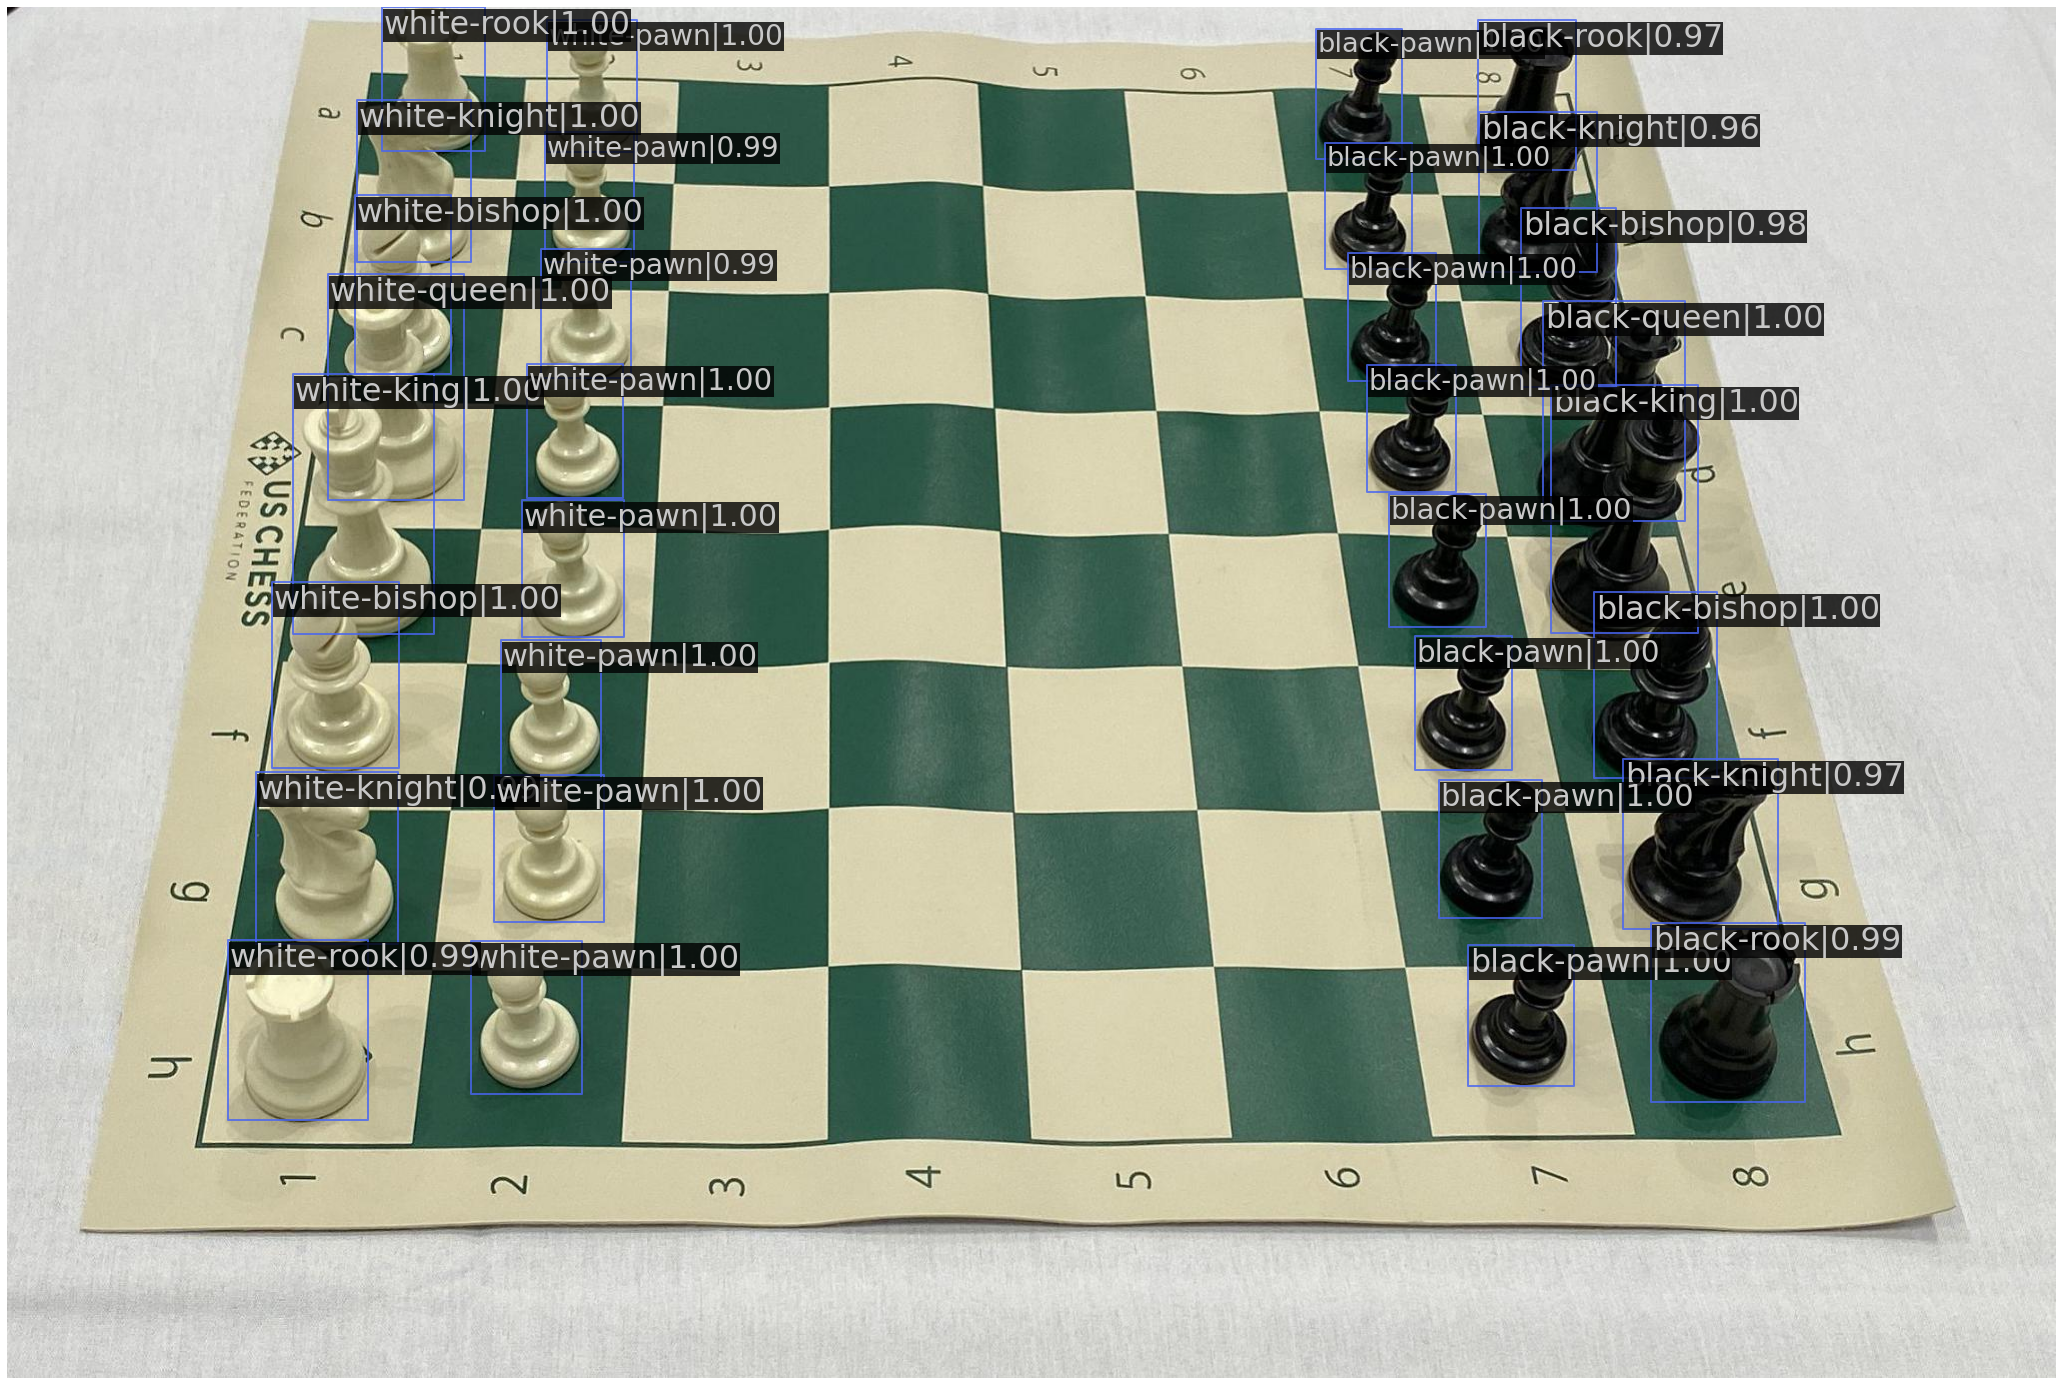

In [25]:
random_show_inference(model)

In [26]:
fi.vis.roi_head_bbox_roi_extractor.shape

torch.Size([200, 256, 7, 7])

In [29]:
for k,feature in fi.vis.items():
    print(k,"-"*60)
    if isinstance(feature,(tuple,list)):
        for f in feature:
            if isinstance(f,(tuple,list)):
                print([ff.shape for ff in f],"\n")
            else:
                print("\n",f.shape,"\n")
    else:
        print(k,"-"*60,"\n",feature.shape,"\n")

rpn_head ------------------------------------------------------------
[torch.Size([1, 3, 200, 304]), torch.Size([1, 3, 100, 152]), torch.Size([1, 3, 50, 76]), torch.Size([1, 3, 25, 38]), torch.Size([1, 3, 13, 19])] 

[torch.Size([1, 12, 200, 304]), torch.Size([1, 12, 100, 152]), torch.Size([1, 12, 50, 76]), torch.Size([1, 12, 25, 38]), torch.Size([1, 12, 13, 19])] 

roi_head_bbox_roi_extractor ------------------------------------------------------------
roi_head_bbox_roi_extractor ------------------------------------------------------------ 
 torch.Size([200, 256, 7, 7]) 

roi_head_bbox_head ------------------------------------------------------------

 torch.Size([200, 14]) 


 torch.Size([200, 52]) 



In [28]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_rpn_result(head_number=0,zoom_scale=0,channel=2):
#     head_number: 0- confidense, 1- bias for x,y,w,h 
#     zoom_scale for proposals: 0~4: 200x304, 100x152, 50x76, 25x38, 13x19
#     channel: featuremap channel 3 type of anchors (w:h ratio)
    im=fi.vis.rpn_head[head_number][zoom_scale][0,channel].detach().to("cpu")
    plt.imshow(F.normalize(im))

可以看到confidence的分布

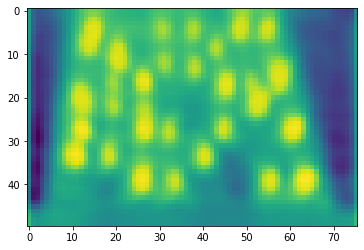

In [22]:
show_rpn_result(head_number=0,zoom_scale=2,channel=1)

In [ ]:
cls_score=[[score for score in s] for s in fi.vis.rpn_head[0]]
bbox_pred=[[bbox for bbox in b] for b in fi.vis.rpn_head[1]]
cls_score=fi.vis.rpn_head[0]
bbox_pred=fi.vis.rpn_head[1]

# model.rpn_head.get_bboxes(cls_scores=cls_score,
#                                   bbox_preds=bbox_pred,
#                                   score_factor_list=None,
#                                   mlvl_anchors=model.rpn_head.prior_generator.base_anchors,
#                                   img_meta={"img_shape":(2048,1371,3)},
#                                   cfg=None)